In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%203%20-%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir -p ../data/sarcasm/
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json -O ../data/sarcasm/sarcasm.json

--2021-02-13 04:48:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.15.112, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘../data/sarcasm/sarcasm.json’

../data/sarcasm/sar 100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-02-13 04:48:26 (245 MB/s) - ‘../data/sarcasm/sarcasm.json’ saved [5643545/5643545]



In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Flatten, Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import History
from tensorflow.keras.backend import clear_session
from tensorflow.compat.v1 import reset_default_graph

clear_session()
reset_default_graph()
# 设置显存自动增长
physical_devices = tf.config.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, enable=True)


vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


with open("../data/sarcasm/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences: [str] = sentences[0:training_size]
testing_sentences: [str] = sentences[training_size:]
training_labels: [int] = labels[0:training_size]
testing_labels: [int] = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index: dict = tokenizer.word_index

training_sequences: [[int]] = tokenizer.texts_to_sequences(training_sentences)
training_padded: np.ndarray = pad_sequences(
    training_sequences, 
    maxlen=max_length, 
    padding=padding_type, 
    truncating=trunc_type
)

testing_sequences: [[int]] = tokenizer.texts_to_sequences(testing_sentences)
testing_padded: np.ndarray = pad_sequences(
    testing_sequences, 
    maxlen=max_length, 
    padding=padding_type, 
    truncating=trunc_type
)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding_1", input_length=max_length),
    Bidirectional(LSTM(units=32, return_sequences=False), name="LSTM_2"),
    Dense(units=24, activation='relu', name="dense_3"),
    Dense(units=1, activation='sigmoid', name="dense_4")
], name="sarcasm_classifier")
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

num_epochs = 50
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history: History = model.fit(
    x=training_padded, 
    y=training_labels, 
    validation_data=(testing_padded, testing_labels), 
    epochs=num_epochs, 
    verbose=1,
    workers=-1,
    use_multiprocessing=True
)

Model: "sarcasm_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
LSTM_2 (Bidirectional)       (None, 64)                12544     
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 17s 13ms/step - loss: 0.5410 - accuracy: 0.7048 - val_loss: 0.3870 - val_accuracy: 0.8205
Epoch 2/50
625/625 [==============================] - 7s 12ms/step - loss: 0.3515 - accuracy: 0.83

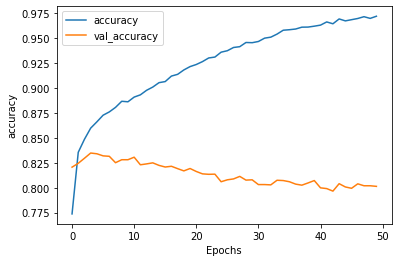

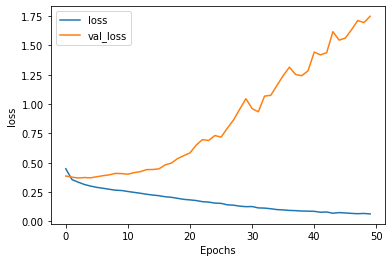

In [6]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [7]:
model.save("../models/test.h5")